# Ch. 1 - descriptive fit analysis

Last access (y.m.d): 21.05.18  
Last update (y.m.d): 21.05.18   

In this notebook, I gather all V1 [or LGN] cells (data, model, descriptive fits) and analyze based on this complete set.

### Table of contents

- Initialize  
- Gather  
- Distribution of tuning measures **(0)**
  - model free measures  
  - comparison with derived measures  
  - comparison with Cavanuagh, other datasets  
- Simple vs complex **(1)**
- Tuning shifts as scatter plots, ratios **(2)**
  - Preferred spatial frequency with contrast 
  - Center of mass with contrast 
  - SFBW with contrast 
  - sfVariance with contrast 
- Trajectories of tuning metrics across contrasts  **(3)**

## Intialize

In [296]:
import pandas as pd
import pdb
import warnings
warnings.filterwarnings(action='once')

In [297]:
import numpy as np
import os
import helper_fcns as hf
# import model_responses as mr
import scipy.stats as ss
from scipy.stats.mstats import gmean
from scipy.stats import ks_2samp, kstest, linregress
import itertools
import autoreload
from IPython.core.display import display, HTML, Image

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');
import matplotlib.cm as cm
import matplotlib.backends.backend_pdf as pltSave
%matplotlib inline
plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');

base_dir = os.getcwd() + '/';

In [298]:
# Before any plotting, fix plotting paramaters
plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');
from matplotlib import rcParams
rcParams['font.size'] = 20;
rcParams['pdf.fonttype'] = 42 # should be 42, but there are kerning issues                                                                                                                                                                                                    
rcParams['ps.fonttype'] = 42 # should be 42, but there are kerning issues                                                                                                                                                                                                     

rcParams['lines.linewidth'] = 2.5;
rcParams['lines.markeredgewidth'] = 0; # no edge, since weird tings happen then
rcParams['axes.linewidth'] = 1.5;
rcParams['lines.markersize'] = 5;

rcParams['xtick.major.size'] = 15
rcParams['xtick.minor.size'] = 8
rcParams['ytick.major.size'] = 15
rcParams['ytick.minor.size'] = 8

rcParams['xtick.major.width'] = 5
rcParams['xtick.minor.width'] = 2
rcParams['ytick.major.width'] = 5
rcParams['ytick.minor.width'] = 2

rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.style'] = 'oblique';
rcParams['font.size'] = 20;

## Gather data

Now, let's create a large list which will combine data/fits/analyses from all cells for all of the above experiments. For each cell, let's keep track of:
* "meta" parameters:
    * which experiment directory
    * which dataList, fitList, descrFit, rvcFit
    * which cell number within those lists
    * which experiment index?
    * which stimulus values (i.e. dispersions, sfs, contrasts)
* inferred parameters:
    * prefSf (for all conditions), along with % var explained
    * c50 (again, for all conditions)
* model parameters
    * fit parameters, loss value for weighted and flat

#### Load the jointList

In [299]:
whichArea = 'V1'; # 'LGN' or 'V1'
wMods = 1; # if wMods 
wModStr = '_wMods' if wMods else ''

fitBase = '210518'; # descriptive fits (rvc,SF tuning)
#fitBase = '210503'; # descriptive fits (rvc,SF tuning)
fitBaseMod = '210331'; # model fits

suffix = '%s%s_210518_vT70_dvT70' % (whichArea, wModStr)
# suffix = 'V1_wMods_210429_vT70_dvT60'
# suffix = 'V1_take2_210331_vT70_dvT60'
# suffix = 'V1_210331_vT70_dvT60'
# suffix = 'V1_200609_vT70_dvT60'
try:
    jointList = hf.np_smart_load(base_dir + 'jointList_%s.npy' % suffix)
    if jointList == []:
        jointList = np.load(base_dir + 'jointList_%s.npy' % suffix, allow_pickle=True);
except: # if it wasn't pickled, then we'll need to just load without the .item which is implicit in hf.np_smart_load
    jointList = np.load(base_dir + 'jointList_%s.npy' % suffix, allow_pickle=True);
#     jointList = np.load(base_dir + 'jointList_%s.npy' % suffix);


saveName = 'figures/reports/descrAnalysis_%s_%s/' % (suffix, whichArea) # for one save name for all figures
save_loc = base_dir + saveName;

In [300]:
### Additional, temporary (for doing _here_) cutting of V1/ cells
# -- for details, see chapter 1 sandbox on choosing from the sorted cells in V1/
to_keep = np.array([1, 3, 5, 7, 8, 10, 11, 13, 14, 15, 16, 17, 19, 21, 22, 23, 27, 28, 29, 31, 34, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,\
 56]);

orig_keys = jointList.keys()
jointListTrim = jointList.copy()


for key in orig_keys:
    expDir = jointList[key]['metadata']['fullPath'].split('/')[-3];
    if expDir == 'V1':
        if jointList[key]['metadata']['cellNum'] not in to_keep:
            jointListTrim.pop(key, None)
            
jointList = jointListTrim.copy()

In [301]:
### Trim the jointList on some criteria?
# A: must have at least one single grating tuning curve which has non-nan varExpl (i.e. > dogVarExplThresh) 
# --- for the diff-of-gauss tuning fit

# Get the keys as ints for easy indexing
keysAsInts = np.array([int(x) for x in jointList.keys()])

prevCells = len(jointList)
critA = np.where([len(np.where(~np.isnan(jointList[x]['metrics']['dog_varExpl'][0,:]))[0]) > 0 for x in sorted(jointList.keys())])[0]

jointListTrim = {key: jointList[keysAsInts[key]] for key in critA}
jointList = jointListTrim

remCells = len(jointList)

nCut = prevCells-remCells

print('We cut %d cells (%.2f%% of the original %d)' % (nCut, 100*nCut/prevCells, prevCells))

# also get the keys as ints for easy indexing
keysAsInts = np.array([int(x) for x in jointList.keys()])

We cut 12 cells (11.01% of the original 109)


#### Compute relevant metrics, gather into pandas structure

In [302]:
### Get relevant metrics at high, one-third, lowest contrast

whichFit = 0; # 0 for flexible gauss, 1 for DoG
prefix = 'dog_' if whichFit else '';

highSf, thirdSf, _ = hf.jl_get_metric_highComp(jointList, '%spSf' % prefix, whichFit, 0)
_, lowSf, compConsSf = hf.jl_get_metric_highComp(jointList, '%spSf' % prefix, whichFit, 1)

highSf70, thirdSf70, _ = hf.jl_get_metric_highComp(jointList, '%ssf70' % prefix, whichFit, 0)
_, lowSf70, compConsSf70 = hf.jl_get_metric_highComp(jointList, '%ssf70' % prefix, whichFit, 1)

highBwHalf, thirdBwHalf, _ = hf.jl_get_metric_highComp(jointList, '%sbwHalf' % prefix, whichFit, 0)
_, lowBwHalf, compConsBwHalf = hf.jl_get_metric_highComp(jointList, '%sbwHalf' % prefix, whichFit, 1)

highBw34, thirdBw34, _ = hf.jl_get_metric_highComp(jointList, '%sbwHalf' % prefix, whichFit, 0)
_, lowBw34, compConsBw34 = hf.jl_get_metric_highComp(jointList, '%sbwHalf' % prefix, whichFit, 1)

sigLow_h, sigLow_t, _ = hf.jl_get_metric_highComp(jointList, 'bw_sigma', 0, 0, extraInds=0)
sigUpper_h, sigUpper_t, compConsSig = hf.jl_get_metric_highComp(jointList, 'bw_sigma', 0, 0, extraInds=1)

_, sigLow_l, _ = hf.jl_get_metric_highComp(jointList, 'bw_sigma', 0, 1, extraInds=0)
_, sigUpper_l, _ = hf.jl_get_metric_highComp(jointList, 'bw_sigma', 0, 1, extraInds=1)


In [306]:
### Get some metadata, relevant tunings
expDir = np.array([jointList[i]['metadata']['fullPath'].split('/')[-3] for i in jointList.keys()])
cellNum = np.array([jointList[i]['metadata']['cellNum'] for i in jointList.keys()])

cellIndex = ['%s/%s' % (e,d) for e,d in zip(expDir, cellNum)]

# cellType = np.array([jointList[i]['metadata']['cellType'] for i in jointList.keys()])
f1f0 = np.array([jointList[i]['metrics']['f1f0_ratio'] for i in jointList.keys()])
disp, con = 0,-1 # high contrast, single grating
highCom = np.array([jointList[i]['metrics']['sfCom'][disp,con] for i in jointList.keys()])

sf_vals = np.array([jointList[i]['metadata']['stimVals'][2] for i in jointList.keys()]);

centralSf = np.copy(highSf); # highSf is prefSf at high contrast
# IF it's undefined, we'll replace with the C.O.M.
whereNan = np.where(np.isnan(centralSf))
centralSf[whereNan] = highCom[whereNan]; 

prefSfInd = [np.argmin(np.square(prefSf - sf_val)) for (prefSf,sf_val) in zip(centralSf, sf_vals)];

# conGain = [jointList[i]['metrics']['conGain'][0, sfInd] for i,sfInd in zip(jointList.keys(), prefSfInd)];
# conGain = np.array([jointList[i]['metrics']['conGain'][0, sfInd] for i,sfInd in zip(jointList.keys(), prefSfInd)]);
c50 = np.array([jointList[i]['metrics']['c50'][0, sfInd] for i,sfInd in zip(jointList.keys(), prefSfInd)]);
c50_eval = np.array([jointList[i]['metrics']['c50_eval'][0, sfInd] for i,sfInd in zip(jointList.keys(), prefSfInd)]);


/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':


In [307]:
### Organize into pandas DF

all_metr = np.vstack((f1f0, #conGain,
                      c50, c50_eval, highSf, thirdSf, lowSf, compConsSf,
                     highSf70, thirdSf70, lowSf70, compConsSf70,
                     highBwHalf, thirdBwHalf, lowBwHalf, compConsBwHalf,
                     highBw34, thirdBw34, lowBw34, compConsBw34,
                     sigLow_h, sigLow_t, sigLow_l, compConsSig,
                     sigUpper_h, sigUpper_t, sigUpper_l));
# cellType, cellType, 
all_names = ['f1f0', #'conGain',
             'c50', 'c50_eval', 'psfHigh', 'psfThird', 'psfLow', 'consLowSf',
            'sf70High', 'sf70Third', 'sf70Low', 'consLowSf70',
            'bwHalfHigh', 'bwHalfThird', 'bwHalfLow', 'consLowBwHalf',
            'bw34High', 'bw34Third', 'bw34Low', 'consLowBw34',
            'sigLowerHigh', 'sigLowerThird', 'sigLowerLow', 'consLowSig',
            'sigUpperHigh', 'sigUpperThird', 'sigUpperLow']

df = pd.DataFrame(all_metr.transpose(), columns=all_names).convert_dtypes(convert_string=False)


In [309]:
# Create first with JUST numeric types
df = pd.DataFrame(np.transpose([f1f0, #conGain, 
                                c50, c50_eval, highSf, thirdSf, lowSf, compConsSf,
                     highSf70, thirdSf70, lowSf70, compConsSf70,
                     highBwHalf, thirdBwHalf, lowBwHalf, compConsBwHalf,
                     highBw34, thirdBw34, lowBw34, compConsBw34,
                     sigLow_h, sigLow_t, sigLow_l, compConsSig,
                     sigUpper_h, sigUpper_t, sigUpper_l]), 
                  index=cellIndex, columns=all_names)
# THEN, add in the non-numeric types
# df.insert(0, 'type', cellType)
df.insert(1, 'expDir', expDir)

<AxesSubplot:xlabel='conGain', ylabel='Count'>

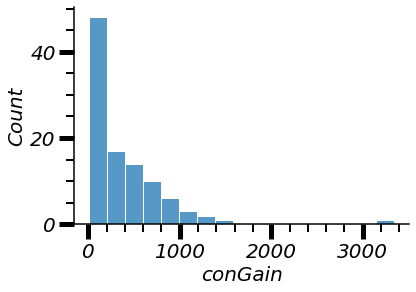

In [293]:
df.groupby('type')
sns.histplot(df['conGain'])

In [310]:
df.groupby('expDir').size()

expDir
V1         34
V1_orig    56
altExp      7
dtype: int64

In [ ]:
56